In [1]:
### - Loading Dependencies
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm                     #Used to set colour gradient on 3D harmonics plot

from scipy.linalg import eig                  # Used to solve for eigenvalue and eigenvectors (Compared various routines)
from scipy.linalg import eigh_tridiagonal     # Used to solve for eigenvalue and eigenvectors (Compared various routines)

from scipy import interpolate                 # Used to interpolate 1D results into function used for 2D plot
from scipy.signal import argrelmax            # Used to find radial local maximas from 1D plot for 3D shells plot
from scipy.special import sph_harm            # Used to generate spherical harmonics in the 3D harmonics plot

In [3]:
### - X Data Generator

#User Settings
N = 8              #(N = 10 makes it easy to verify the results by hand in this early stage)
x_min = -5
x_max = 5

#Creating spatial range generator as a function for repeated use throughout program
def generate_x(x_min, x_max, N):
    delta_x = (x_max - x_min)/N
    x = np.arange(x_min, x_max + delta_x, delta_x) #arguments(min,max,step_size) max is given as x_max + delta_x as it is non inclusive of maximum, adding one more increment of delta_x fixes this and auto scales with user choice of N
    return(x, delta_x, N)

#Generate array of N+1 discrete x values ranging from x_min to x_max  
x, delta_x, N = generate_x(x_min=x_min, x_max=x_max, N=N)

X_Array: [-5.   -3.75 -2.5  -1.25  0.    1.25  2.5   3.75  5.  ]


In [5]:
### - Potential Energy Function for Quantum Harmonic Oscillator
def potential_qho(x):
    """
    Input: x: Discrete spatial x values as N x 1 array.
    
    Returns: v: N x 1 array with the corresponsing potential energy of the QHO at each x value.
    """
    v = x**2       #Quantum Harmonic Oscillator Potential Energy
    return v

#Calculate Potential using function
V_qho = potential_qho(x)   

# Part 2

The following function, given the discrete space points $x_i$ and the potential $V_i$, constructs and returns the Hamiltonian matrix.

///////
Have done two differnt methods of hamiltonian, the first constructs the full matrixs, and is used as input for the scipy eig solver. The scond hamiltonian method creates just the diagonals of the tridiagonal matrix, and is used with the scipy tridiag solver

In [7]:
###Hamiltonian Matrix Function               #Further on in the code i have used the scipy eig solver to calculate eigenvalaues and eigenvectors, this fucntion creates the hamiltonian matrix in the format expected by the eig solver (M x M tridiagonal)
def hamiltonian_matrix(x, V, delta_x):
    """
    Input: x: Discrete x values as N x 1 array, 
           V: Potential Energy values as N x 1 array, 
           delta_x: The step size (dx) as a single float
    
    Returns: H: Hamiltonian as a M x M tridiagonal matrix
    
    """
    #The kinetic energy term of the Hamiltonian  
    D = np.zeros((len(x),len(x)))          #Creates an M x M array with M equal to the length of array 'x'
    
    for i in range(0, len(x)):             #Iterates through rows of D
        for j in range(0, len(x)):         #Iterates through columns of D
            if i == j:                     #Checks if row and column index are equal (only the case on the leading diagonal)
                D[i][j] = 2/(delta_x**2)   #If above check is true then the value in the index is updated to 2/(delta_x**2)
            if i == j-1 or i == j+1:       #Checks if column index is equal to row-1 or row+1 index (only the case on the two diagonals around the leading diagonal)
                D[i][j] = -1/(delta_x**2)  #If above check is true then the value in the index is updated to -1/(delta_x**2) 

    #The potential energy term of the Hamiltonian  
    v_psi = np.zeros((len(x),len(x)))      #Creates an M x M array with M equal to the length of array 'x'   
    
    for i in range(0, len(x)):             #Iterates through rows of D
        for j in range(0, len(x)):         #Iterates through columns of D
            if i == j:                     #Checks if row and column index are equal (only the case on the leading diagonal)
                v_psi[i][j] = V[i]         #If above check is true then the value in the index is filled with the corresponding value from the potential energy array V
    
    #The Hamiltonian matrix, 𝐻=𝐷+𝑉
    H = D + v_psi                          #Creates the M x M Hamiltonian matrix by element wise addition of the Kinetic and Potential energy terms
    return H                               #Returns the Hamiltonian M x M matirx

In [8]:
###Hamiltonian tridiag Function                      #This is a different hamiltonian function, further on in the code i compared differnt scipy solvers, this function creates the hamiltonian in the format expectd by eigh.tridiagonal solver to calculate eigenvalaues and eigenvectors, this fucntion creates the hamiltonian leading and ofset diagnonals only not the entire matrix 
def hamiltonian_diag(x, V, delta_x):
    """
    Input: x: Discrete x values as N x 1 array, 
           V: Potential Energy values as N x 1 array, 
           delta_x: The step size (dx) as a single float
    
    Returns: H_main: Hamiltonian leading diagonal as 1D array, 
             H_plusone: Hamiltonian ofset diagonal as 1D array.
    """
    #The kinetic energy term of the Hamiltonian  
    D_main = np.full(len(x), fill_value=2/(delta_x**2))           #Creates a 1D array of same length of x where each value is 2/(delta_x**2
    D_plusone = np.full(len(x)-1 , fill_value=-1/(delta_x**2))    #Creates a 1D array of same length of x-1 (Ofset diagonals length is 1 less than on the leading diagonal), where each vlue is -1/(delta_x**2)

    #The Hamiltonian matrix, 𝐻=𝐷+𝑉                                #V is not calculated in function as it is passed n as argument already in the correct 1D format
    H_main = D_main + V                                           #Creates the 1D hamiltonain leading diagonal by combining the Kinetic and Potential energy arrays leading diagonals values
    H_plusone = D_plusone                                         #Creates the 1D hamiltonain ofset diagonal by combining th Kinetic and Potential energy arrays ofset diagonals values (Potential energy ofset diagonalas are all 0 so just the Kinetic energy term is used)
    
    return(H_main, H_plusone)                                     #Returns the Hamiltonian 1D leading diagonal and the Hamiltonian 1D offset diagonal

Test your function by printing the matrix it returns.  You can use small $N$ and check a few elements by hand to ensure they are correct.

In [9]:
### - Hamiltonian matrix from hamiltonian_matrix function for the scipy eig solver
H_matrix = hamiltonian_matrix(x, V_qho, delta_x)         
print("Hamiltonian Matrix:\n")
print(H_matrix)

Hamiltonian Matrix:

[[26.28   -0.64    0.      0.      0.      0.      0.      0.      0.    ]
 [-0.64   15.3425 -0.64    0.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.64    7.53   -0.64    0.      0.      0.      0.      0.    ]
 [ 0.      0.     -0.64    2.8425 -0.64    0.      0.      0.      0.    ]
 [ 0.      0.      0.     -0.64    1.28   -0.64    0.      0.      0.    ]
 [ 0.      0.      0.      0.     -0.64    2.8425 -0.64    0.      0.    ]
 [ 0.      0.      0.      0.      0.     -0.64    7.53   -0.64    0.    ]
 [ 0.      0.      0.      0.      0.      0.     -0.64   15.3425 -0.64  ]
 [ 0.      0.      0.      0.      0.      0.      0.     -0.64   26.28  ]]


In [10]:
### - Hamiltonian diagonals from hamiltonian_diag function for the scipy tridiagonal solver
H_main, H_plusone = hamiltonian_diag(x, V_qho, delta_x)
print("Hamiltonian Main Diagonal:", H_main)
print("Hamiltonian +-1 Diagonal:", H_plusone)

Hamiltonian Main Diagonal: [26.28   15.3425  7.53    2.8425  1.28    2.8425  7.53   15.3425 26.28  ]
Hamiltonian +-1 Diagonal: [-0.64 -0.64 -0.64 -0.64 -0.64 -0.64 -0.64 -0.64]


In [11]:
#Checking values are equal from both methods and diagonal lengths are the same (More usefull when the arrays are too large to check visually)

if np.array_equal(H_main, np.diagonal(H_matrix)):               #Compares the 1D main array to the values in the leading diagonal in the tridagonal array
    print("Main Diagonal Match Verified")                       #User feedback on above condition

if np.array_equal(H_plusone, np.diagonal(H_matrix, offset=1)):  #Compares the 1D offset array to the values in the ofset diagonal in the tridagonal array
    print("Ofset Diagonal Match Verified")                      #User feedback on above condition


Main Diagonal Match Verified
Ofset Diagonal Match Verified


In [19]:
# camparing the speed of both methods using the timeit module

import timeit

#Timing the hamiltonian_matrix function
time_matrix = timeit.timeit('hamiltonian_matrix(x, V_qho, delta_x)', globals=globals(), number=100000)

#Timing the hamiltonian_diag function
time_diag = timeit.timeit('hamiltonian_diag(x, V_qho, delta_x)', globals=globals(), number=100000)

print("Time for Hamiltonian Matrix Function:", time_matrix)
print("Time for Hamiltonian Diag Function:", time_diag)


Time for Hamiltonian Matrix Function: 2.215260100000023
Time for Hamiltonian Diag Function: 0.44499170000000277


# Part 3

Now find the first 10 eigenvalues of the quantum harmonic oscillator Hamiltonian using an appropriate scipy routine. You should use a large number of $x$ points, at least 1000, covering sufficient range that the wavefunction falls to zero at the extremities. You should compare the computed eigenvalues with the expected eigenvalues.

In [11]:
### - Analytical Quantum Harmonic Oscillator Eigenvalues
def qho_analytical_e_vals(maxE_val):
    """
    Input: maxE_val: maximum desired eigenvalue
    
    Returns: analytical_E_vals: 1D list of analytical eigenvales for the QHO from ground state up till maxE_val
             n_vals: 1D list of index positions for the analytical eigenvales
    """    
    analytical_E_vals=[]                           #Initialises list to hold the analytical eignevalues
    n_vals=[]                                      #Initialises list to hold the index n 
    
    for n in range (0,maxE_val):                   #Iterates through the values of n up to the maximum user desired eignevalue (maxE_val)
        analytical_E_vals.append((n*2)+1)          #Calculates (and appends to the list) the analytical eigenvalues, which are given by (n*2)+1 due to the choice of units we have used for energy (ℏ/𝑚𝜔)
        n_vals.append(n)                           #Appends the index to its list   
        
    return(analytical_E_vals, n_vals)              #Returns the list of eigenvalues and the list of index values

In [12]:
### - Testing solvers vs QHO analytical soloution to quantify error 
def compare_solvers_to_analytical(N, maxE_val, potential_function=potential_qho, analytical_function=qho_analytical_e_vals, sorting_fix=0):
    """
    Input: N: Int value for number of points to divide the spatial range into, 
           maxE_val: maximum desired eigenvalue, 
           potential_function: pass in function for potential energy (allows this to be used for both QHO and Hydrogen)
           analytical_function: pass in function for analytical eigenvalues (allows this to be used for both QHO and Hydrogen)
           sorting_fix: pass in 0 [off] or 1 [on] if set to 1 the output of the scipy eig solver is sorted before being returned (as it retunrs values in random ordering as you shall see further in the program)
    
    Returns:
    """      
    if potential_function == potential_qho:
        #Generate array of N+1 discrete x values ranging from -5 to 5
        x, delta_x, N = generate_x(x_min=-5, x_max=5, N=N)
        
    elif potential_function == potential_hydrogen:
        #Generate array of N+1 discrete r values ranging from 0 to 300
        x, delta_x, N = generate_x(x_min=0, x_max=300, N=N)    #these are actually r, and delta_r but keeping the name the same saves double coding all the rest of this function 

    #Calculates potential based on the passed in function
    V = potential_function(x)
    
    #Calculates the hamiltonian using both methods (full matrix vs only filled diagonals)
    H_matrix = hamiltonian_matrix(x, V, delta_x)
    H_main, H_plusone = hamiltonian_diag(x, V, delta_x)

    ###Eigenvalue & Eigenvector Solvers
    E_vals, E_vectors = eig(H_matrix)    #scipy.linalg.eig
    E_vals_tridiag, E_vectors_tridiag = eigh_tridiagonal(H_main, H_plusone)        #scipy.linalg.eigh_tridiagonal
    
    #Eig random ordering fix - Discussed fully after the plots below!
    if sorting_fix == 1:
        E_vals = np.sort(E_vals)
    
    #Calcualates analytical eigenvalues
    analytical_E_vals, n_vals = analytical_function(maxE_val)
    
    #Calculating error of scipy solvers relative to the known analytical results
    eig_error_vals = abs(analytical_E_vals - E_vals[0:maxE_val].real)
    tridiag_error_vals = abs(analytical_E_vals - E_vals_tridiag[0:maxE_val].real)

    #Protection for upcoming plotting from user having set 'n' value greater than 'N' (n = number of eigenvalues to plot, N = number of points in x range)
    if maxE_val > N:
        raise ValueError('User selected value for n (n = %s)' %maxE_val, 'must be equal to or less than N (N = %s)' %N)

    ### - Plotting
    plt.subplots(nrows=1, ncols=2, figsize=(12, 4), tight_layout=True)
    
    #plotting analytical results vs n compared to my results vs n
    plt.subplot(1,2,1)
    plt.title("Comparison of Scipy solvers to analytical result with N=%s" %N)
    plt.xlabel("Eigenvalue number (n)")
    plt.ylabel("Energy (UNITS)")
    plt.scatter(n_vals,analytical_E_vals, c='r', label='Analytical',)
    plt.plot(n_vals,E_vals[0:maxE_val].real, c='b', label='Scipy eig')
    plt.plot(n_vals,E_vals_tridiag[0:maxE_val].real, c='g', label='Scipy tridiagonal')
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend()

    #Plotting error vs n
    plt.subplot(1,2,2)
    plt.title("Error in scipy solvers reletive to analytical result with N=%s" %N)
    plt.xlabel("Eigenvalue number (n)")
    plt.ylabel("Abs Error")
    plt.plot(n_vals,eig_error_vals, c='b', label='Scipy eig')
    plt.plot(n_vals,tridiag_error_vals, c='g', label='Scipy tridiagonal')
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.show()
    
    return (E_vals, E_vectors, eig_error_vals, E_vals_tridiag, E_vectors_tridiag, tridiag_error_vals, x, V)


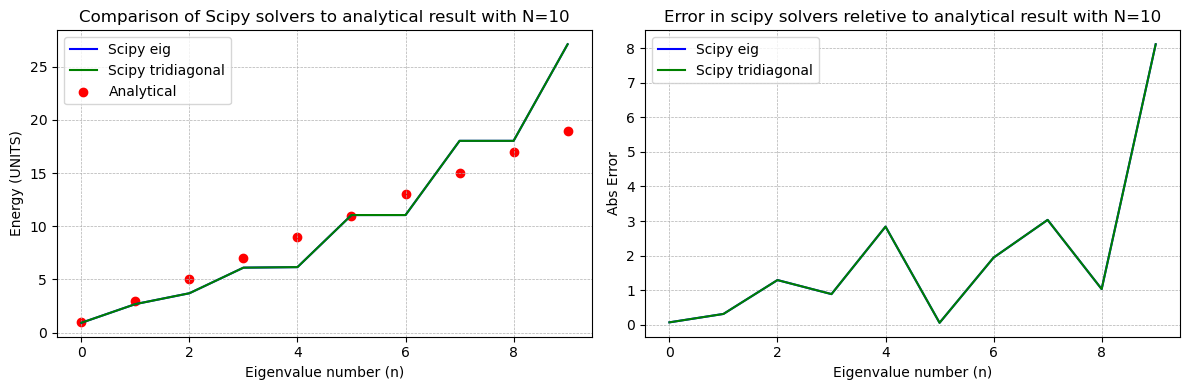

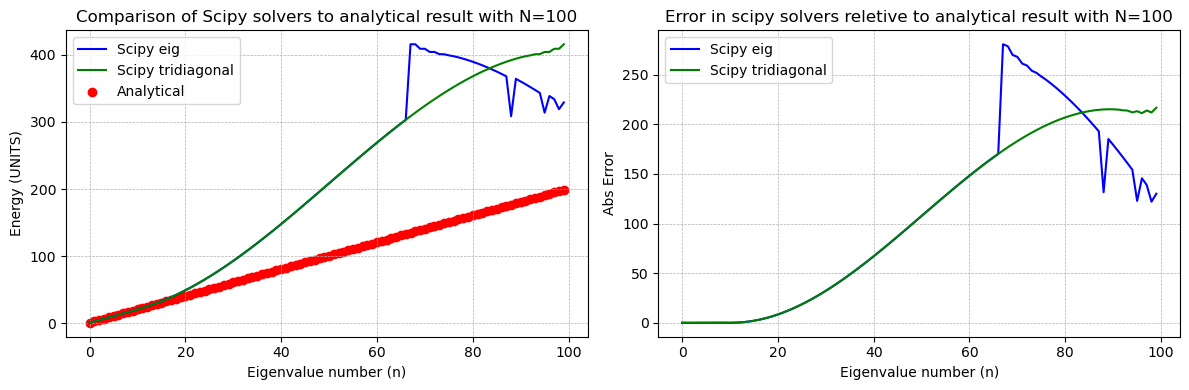

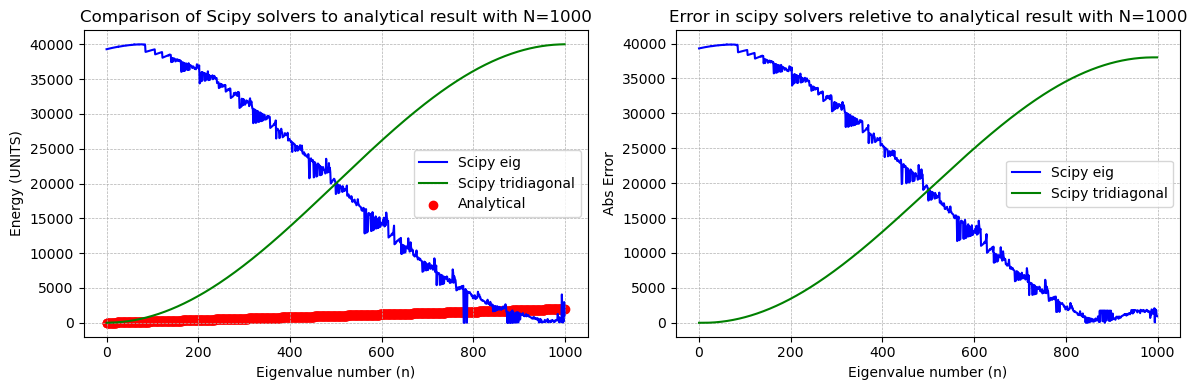

In [13]:
### - Plotting comparison between analytical result and Scipys eig and eigh.tridiag solvers across a range of N values (the number of points to discretise the spatial range into) 
compare_solvers_to_analytical(N=10, maxE_val=10)        #N=10
compare_solvers_to_analytical(N=100, maxE_val=100)      #N=100
compare_solvers_to_analytical(N=1000, maxE_val=1000);   #N=1000, the semicolon at end of line stops jupiter notebook printing the return of the final function call as i have not set it to a variable

There seems to be some kind of strange behavior with the eig function which returns reasonable values when run under approx N = 120 but above this value it goes haywire, whereas the tridiagonal fucntion behaves properly

I was quite confused by this at first as it does produce the correct values if you only check the first few. I first wrote extra bit of code above that compares the diagoanls from the matrixs im generating to the flat arrays made for the triadiag method just to make sure that somehow the matrix generation is messing up when i change N, but it was fine. 

Discovered what the issue was in the eig documentation, resutls are not ordered, was confused by the fact that the results are ordered for the first x values when the value of N selected is low. Added quick fix into my above function 'compare_solvers_to_analytical()' by using quicksort from np.sort() to sort the returned reults from the eig and with that the results exactly match those from the tridiag function for all selected choices of N as shown below.

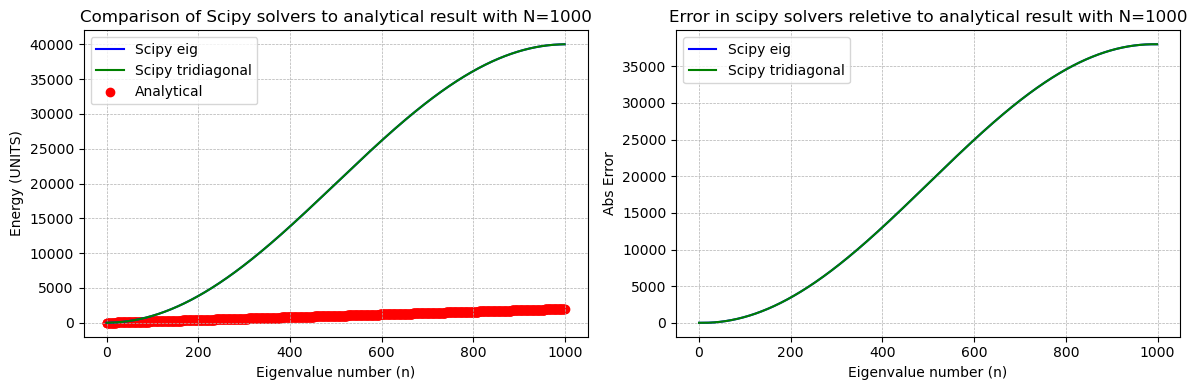

In [14]:
_, _, _, E_vals_tridiag, E_vectors_tridiag, tridiag_error_vals, x, V_qho = compare_solvers_to_analytical(N=1000, maxE_val=1000, sorting_fix=1);    #Same as the above but now with the sorting fix applied for the eig solver

Both solvers now match but from the plots we can see that they diverge from the expected analytical result very strongly as the eigenvalue number 'n' gets large


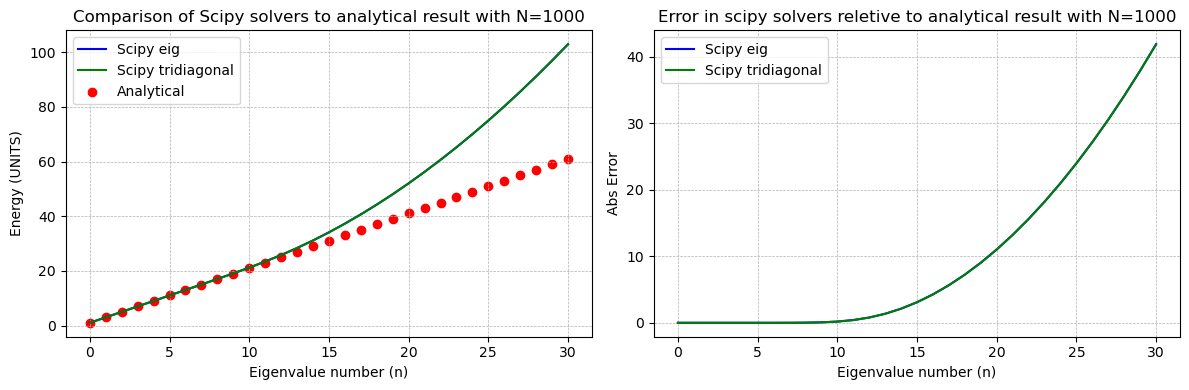

In [15]:
compare_solvers_to_analytical(N=1000, maxE_val=31, sorting_fix=1);     #Same as above with N remaining at 1000, have just plotted a zoomed in portion fo the plot only up to the 30th eigenvalue, to see how the numerical results compare to the analytical at low values of E_n

As we will be keeping to a reletivly low number of n (approx 10) the error remains small

In [16]:
### - QHO Analytical Eigenvectors Function
def qho_analytical_e_vectors(x, n):
    """
    Input: x: range of x to calculate eigenvector over
           n: energy eigenvalue index of eigenvector to return
    
    Returns: wavefunc: The eigenvector of energy E_n over the range x
             prob_density: The probability density (wavefunction**2) over range x 
    """

    term_n = [((1/(np.sqrt(np.pi)))**(1/2)) * np.exp(-(x**2)/(2)),                                  #Analytical Eigenvector 1
              ((2/(np.sqrt(np.pi)))**(1/2)) * (x) * np.exp(-(x**2)/(2)),                            #Analytical Eigenvector 2
              ((2/(np.sqrt(np.pi)))**(1/2)) * ((x**2)-(1/2)) * np.exp(-(x**2)/(2)),                 #Analytical Eigenvector 3
              (2 * ((1/(3 * np.sqrt(np.pi)))**(1/2)) * (x) * ((x**2)-(3/2)) * np.exp(-(x**2)/(2)))] #Analytical Eigenvector 4       
    
    wavefunc = term_n[n]                #Selects the analytical eigenvector from above list corresponding to the input value n
    prob_density = wavefunc**2          #Squares the wavefunction to arrive at the probability density
    return (wavefunc, prob_density)     #Returns the wavefunction and probability density 


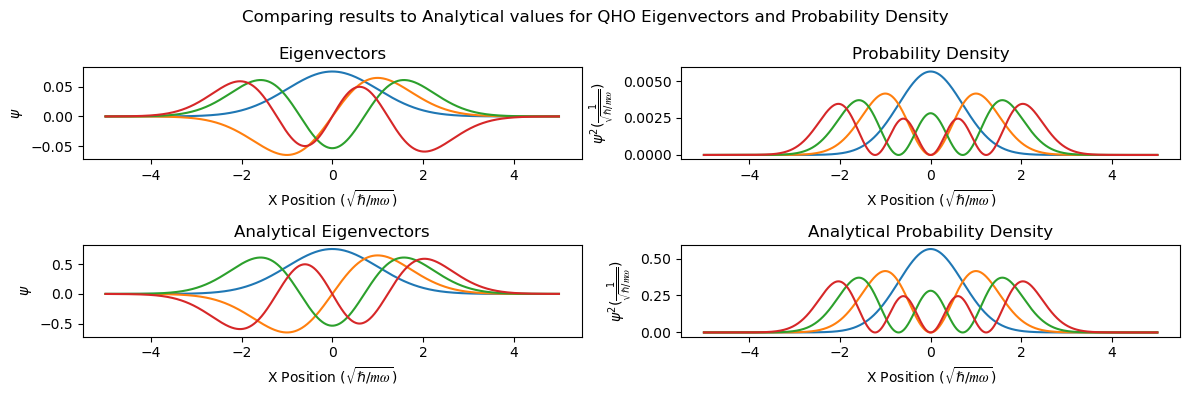

In [17]:
### - Plotting Comparison of QHO Eigenvectors results to Analytical Soloutions
xlabel1 = 'X Position $(\sqrt{ℏ/𝑚𝜔})$'  
ylabel1 = '$\psi$'
ylabel2 = '$\psi^2 (\\frac{1}{\sqrt{ℏ/𝑚𝜔}})$'
title1 = 'Eigenvectors'
title2 = "Probability Density"

plt.subplots(figsize=(12, 4), tight_layout=True)
plt.suptitle("Comparing results to Analytical values for QHO Eigenvectors and Probability Density")

plt.subplot(2,2,1)            #Numerical Eigenvectors
for n_indx in range (0,4):
    SimplePlotAssist(x, E_vectors_tridiag[:,n_indx], title=title1, xlabel=xlabel1, ylabel=ylabel1)

plt.subplot(2,2,2)            #Numerical Probability Density
for n_indx in range (0,4):
    SimplePlotAssist(x, E_vectors_tridiag[:,n_indx]**2, title=title2, xlabel=xlabel1, ylabel=ylabel2)

plt.subplot(2,2,3)            #Analytical Eigenvectors
for n_indx in range (0,4):
    analytical_wavefunc = qho_analytical_e_vectors(x, n_indx)[0]
    SimplePlotAssist(x, analytical_wavefunc, title="Analytical " + title1, xlabel=xlabel1, ylabel=ylabel1)
    
plt.subplot(2,2,4)            #Analytical Probability Density
for n_indx in range (0,4):
    analytical_probability = qho_analytical_e_vectors(x, n_indx)[1]
    SimplePlotAssist(x, analytical_probability, title="Analytical " + title2, xlabel=xlabel1, ylabel=ylabel2)
    
plt.show()    

Next you should plot the wavefunctions, ie. the eigenvectors.  Rather than plot the wavefunction directly, you should plot the probability density, which is given by $\psi^2$, and indicates the probability to find the particle at position $x$.

In [18]:
### - Function for QHO - (Now with the testing done clean function for the whole QHO calculation without all the testing loops and analytical checking etc, and only using the prefered scipy solver, eigh.tridiag)
def QHO_Calculator(N, maxE_val):
    """
    Input: N: Int value for number of points to divide the spatial range into, 
           maxE_val: maximum desired eigenvalue, 
    
    Returns:x: Discrete x values as N x 1 array, 
            delta_x: The step size (dx) as a single float,
            N: Int value for number of points to divide the spatial range into,
            V_qho:, Potential Energy values as N x 1 array,
            E_vals_tridiag: List of numerically calculated eigenvalues, 
            E_vectors_tridiag List of numerically calculated eigenvectors
    """  
    x, delta_x, N = generate_x(x_min=-5, x_max=5, N=N)                           #Spatial Discretisation  function 
    V_qho = potential_qho(x)                                                     #QHO potential function
    H_main, H_plusone = hamiltonian_diag(x, V_qho, delta_x)                      #Hamiltonian function
    E_vals_tridiag, E_vectors_tridiag = eigh_tridiagonal(H_main, H_plusone)      #Eigen vector/value solver
    return(x, delta_x, N, V_qho, E_vals_tridiag, E_vectors_tridiag)              #Returns all calulated values and steps for further processing or visulisation

In [19]:
x, delta_x, N, V_qho, E_vals_tridiag, E_vectors_tridiag = QHO_Calculator(100, maxE_val=100);

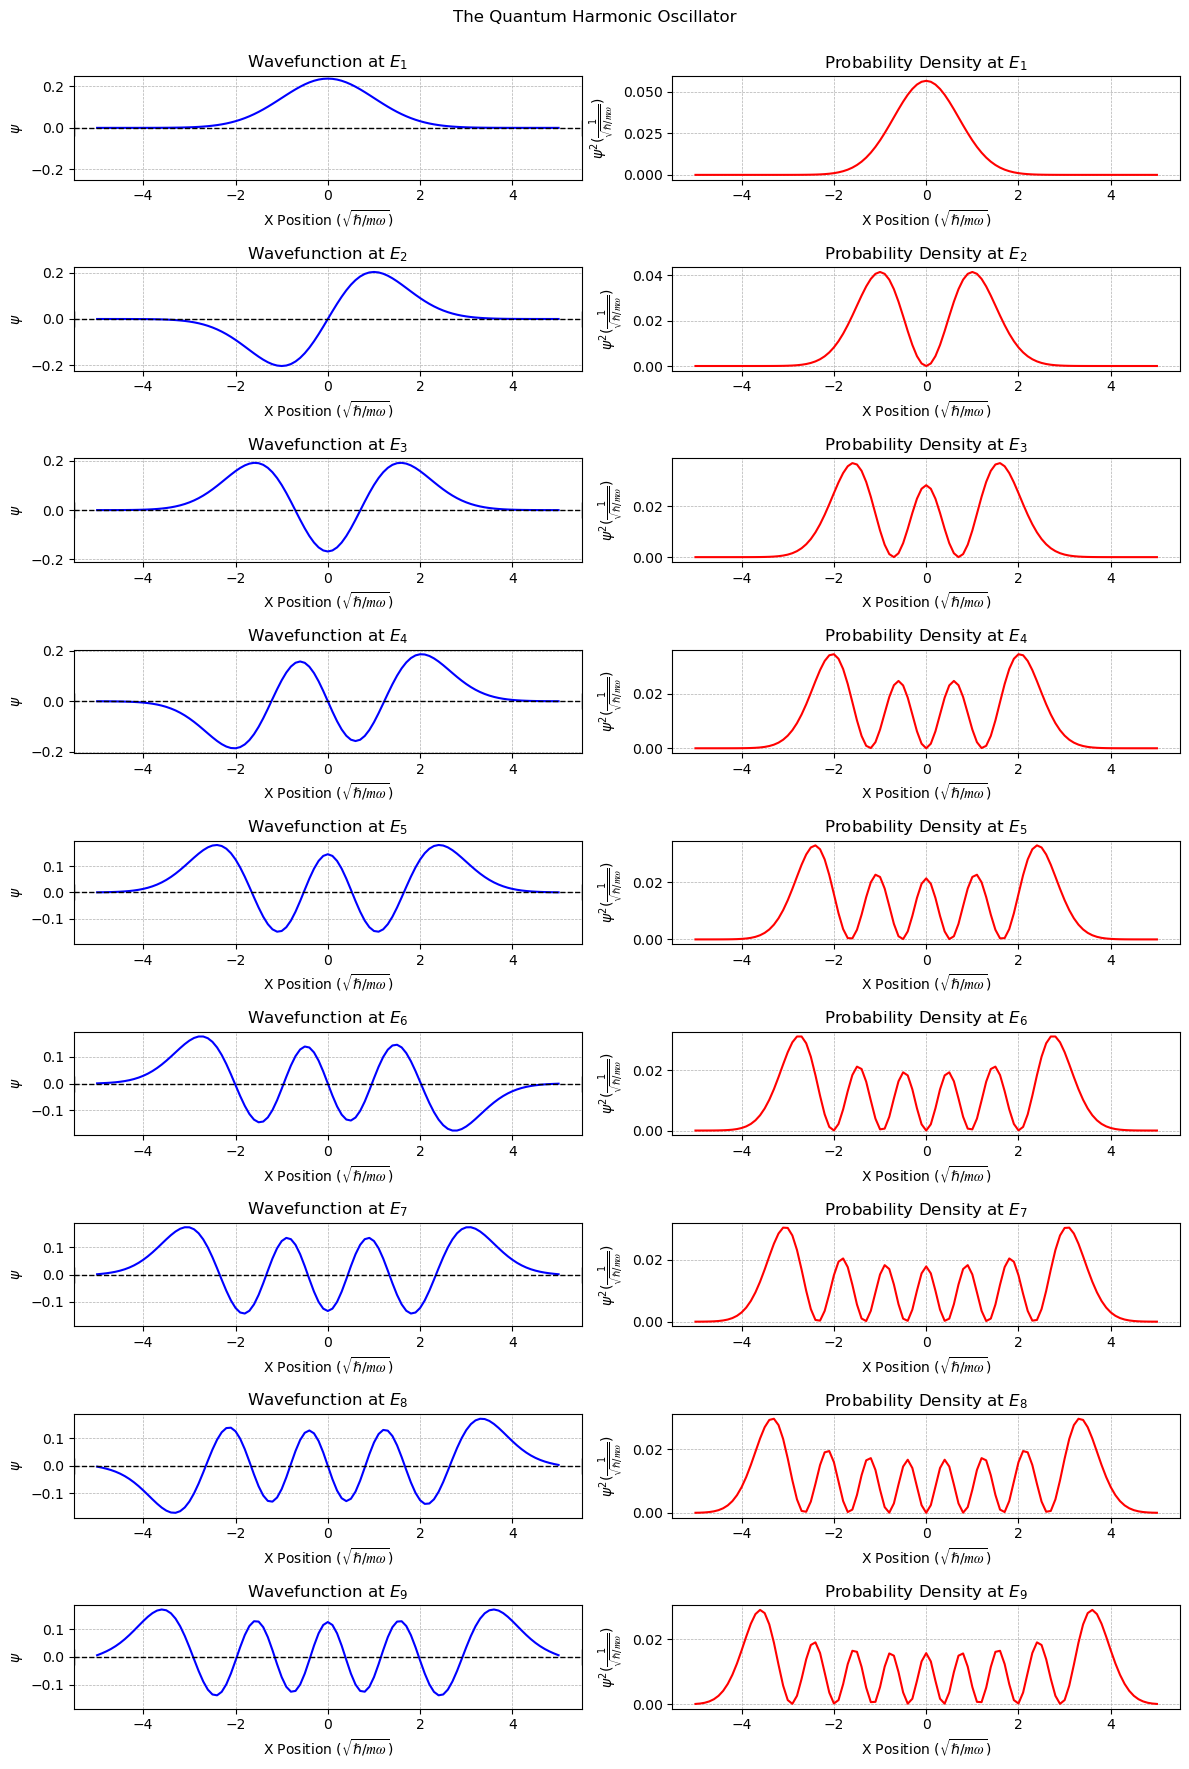

In [20]:
### - Seperate Eigenstate (Wavefunction) and Probability Density (Wavefunction**2) Plots for Quantum Harmonic Oscillator

#User Settings
maxE_vec = 9    # Max number of eigenvectors to plot

#Plot - Setup
title = "Wavefunction at "   #is appended with the eigenstate number in the plot
title_2 = "Probability Density at "
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "$\psi$" 
ylabel_2 = "$\psi^2 (\\frac{1}{\sqrt{ℏ/𝑚𝜔}})$" 

#Plotting
rows=maxE_vec
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(12, rows*2), tight_layout=True)
plt.suptitle("The Quantum Harmonic Oscillator\n \n ")

for i_ax, ax in enumerate(axes.flat):
    n = i_ax//2
    if ((i_ax) % 2) == 0:          #WAVEFUNCTION PSI
        SimplePlotAssist(x, E_vectors_tridiag[:,n], xlabel=xlabel, ylabel=ylabel, ax_mode=1, title=title + "$E_%s$" %(n+1), symetrical=1)
        ax.axhline(y=0 , color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)
        ax.grid(linestyle = '--', linewidth = 0.5)

    else:                          #PROBABILITY PSI**2
        SimplePlotAssist(x, E_vectors_tridiag[:,n]**2, xlabel=xlabel, ylabel=ylabel_2, colour='r', ax_mode=1, title=title_2 + "$E_%s$" %(n+1))    
        ax.grid(linestyle = '--', linewidth = 0.5)

plt.show()

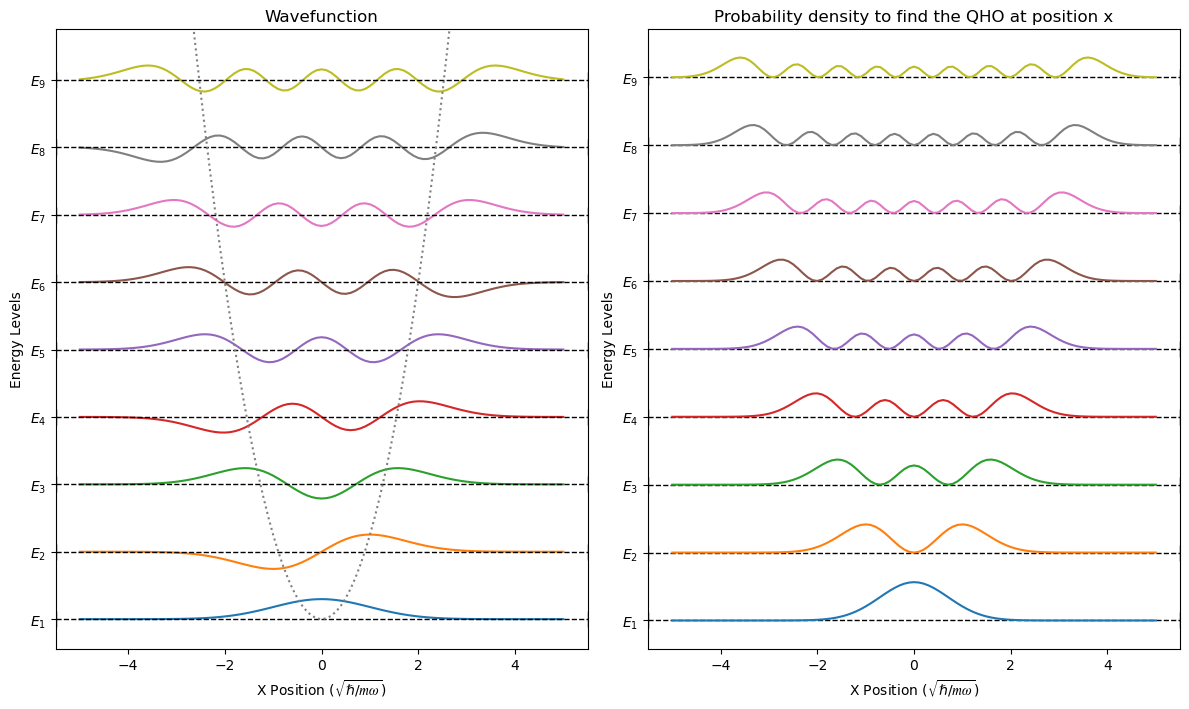

In [21]:
### - Condensed Wavefunction and Probability Density Plots for Quantum Harmonic Oscillator Showing Potential 

#Plot - Setup
title = "Wavefunction"
title_2 = "Probability density to find the QHO at position x"
xlabel = "X Position $(\sqrt{ℏ/𝑚𝜔})$"
ylabel = "Wavefunction $(\psi)$" # (𝜓)")#font error on psi
ylabel_2 = "Probability Density" # (𝜓2)")#font error on psi

#Internal Program Setup 
Eslice = E_vectors_tridiag[:,0:maxE_vec]

#Changes plot height scaling factor when under 4 plots high to keep pleasent viewing size
if maxE_vec <= 4:
    scaled_height = 2 * maxE_vec
else:
    scaled_height = 0.8 * maxE_vec

### - Plotting    
plt.subplots(nrows=1, ncols=2, figsize=(12, scaled_height), tight_layout=True)
y_ticks = []
tick_locations = []
tick_locations_2 = []


plt.subplot(1,2,1)                    #WAVEFUNCTION PSI
for n in range(0, maxE_vec):
    offset = n * 0.8                  #Sets an ofset scaling value so that each successive wavefunction is is offset from the previous on the plot
    y_ticks.append("$E_%s$" %(n+1))   #Sets the y axis labeles with the corresponding eigenvalue index E_n
    tick_locations.append(offset)     #Sets the y axis tick locations to fall on each ofset waves centre
    ylabel = "Energy Levels"
    
    SimplePlotAssist(x, Eslice[:,n] + offset, title=title, xlabel=xlabel, ylabel=ylabel)               #Plots wavefunction against spatial range x
    plt.axhline(y=offset, color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)   #Adds a central line indicating y = 0 as a guide to the eye 

plt.yticks(ticks=tick_locations, labels=y_ticks)       #Plots the created y labels
plt.plot(x, V_qho, c='grey', linestyle='dotted')       #Once all wavefunctions are plotted, this line plots the potential we calulated earlier on the same graph to visualise the classical limits
plt.ylim(-0.35,7)                                      #This just trims the potential to the same limits as the wavefunction graph so it is displayed at correct scaling reletive to the probability density plot beside


plt.subplot(1,2,2)                     #PROBABILITY PSI**2
for n in range(0, maxE_vec):           #Sets an ofset scaling value so that each successive probability density plot is is offset from the previous on the plot
    offset = n / 10
    tick_locations_2.append(offset)    
    ylabel_2 = "Energy Levels"
    plt.axhline(y=offset, label="$E_%s$" %(n+1), color='black', marker='|', linestyle='dashed', linewidth=1, markersize=12)
    SimplePlotAssist(x, Eslice[:,n]**2 + offset, title=title_2, xlabel=xlabel, ylabel=ylabel_2)       #Plots probability density against spatial range x
plt.yticks(ticks=tick_locations_2, labels=y_ticks) 

plt.show()




The dotted u shape line shows the potential that we caluclated, combining the potential and the wavefunctions on this one plot allows us to see the classical limits, where the potential crosses each wavefunction. Classically the wavefucntion is not allowed to have a value other than 0 past these limits (turning points) but we can see here that it does, this is one of the dissagremments between classical and quantum theory.

# Part 4

Having verified our method, we can use it to find the eigenvalues of a more complex system - the Hydrogen atom.  In a spherically symmetric system, the wavefunction can be written :

$$\frac{1}{r}\Psi(r)Y_{lm}(\theta, \phi)e^{i m\phi}$$

where $Y_{lm}(\theta, \phi)$ are the spherical harmonic functions and l, m are the angular momentum quantum numbers. The radial function $\Psi(r)$ satisfies the time-independent Schrödinger equation, provided a suitable term is added to the potential.

If we use the Bohr radius $a_0$ as the unit $r$, where :
$$a_0 = \frac{4 \pi \epsilon \hbar^2}{m_e e^2}$$

then the energy will be measured in units of :
$$\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$$

and the potential for the hydrogen atom can be written :

$$V(r_i) = \frac{-2}{r_i} + \frac{l(l+1)}{r_i^2}$$

Write a function which takes as argument a discrete set of points, $r_i$, and returns the potential $V_i$. You should use a range of $r$ such that the wavefunction become negligible - 200 Bohr radii should be sufficient.  Note that $r$ must now be positive.

In [22]:
### - r Data Generator

#User Inputs 
min_r = 0         #Maximum radial value in units of 𝑎0 (where a0 is the bohr radius)
max_r = 250       #Minimum radial value in units of 𝑎0 
N = 1000          #Number of points to divide radius into 

r, delta_r, N = generate_x(x_min=min_r, x_max=max_r, N=N)    #X spatial genrator fucntion defined earlier works fine for r too

In [23]:
### - Potential Energy Function for Hydrogen Atom
def potential_hydrogen(r, l=0):
    """
    Input: r: Discrete radius values as N x 1 array,
           l: Angular momentum quantum number [defaults to 0 if not set]
    
    Returns: V_hyd: N x 1 array with the corresponsing potential energy of the Hydrogen electron at each radial value.
    """    
    V_hyd = -2/xs + (l*(l+1)/xs**2)                                 #Sets that index in the potential array to 0 as it is the site of the hydrogen nuclus and the electron cannot be inside it 
    return V_hyd                                         #Returns the potential energy of the hydrogen electron across the radial range r

### - Potential Energy Function for Hydrogen Atom
def potential_hydrogen2(r, l=0):
    """
    Input: r: Discrete radius values as N x 1 array,
           l: Angular momentum quantum number [defaults to 0 if not set]
    
    Returns: V_hyd: N x 1 array with the corresponsing potential energy of the Hydrogen electron at each radial value.
    """    
    term_1 = np.divide(-2,r, where=(r!=0))               #Divides -2 by each value in r unless the r value is 0 (to avoid divide by zero error)
    term_2 = np.divide((l*(l+1)), r**2, where=(r!=0))    #Divides (l*(l+1) by each value**2 in r unless the r value is 0 (to avoid divide by zero error)
    V_hyd = term_1 + term_2                              #Calulates the potential of the hydrogen electron from the two terms above
    centre = np.where(r == 0)[0]                         #Finds the index for the point in r which is 0 and the division was skipped
    V_hyd[centre] = 0                                    #Sets that index in the potential array to 0 as it is the site of the hydrogen nuclus and the electron cannot be inside it 
    return V_hyd                                         #Returns the potential energy of the hydrogen electron across the radial range r


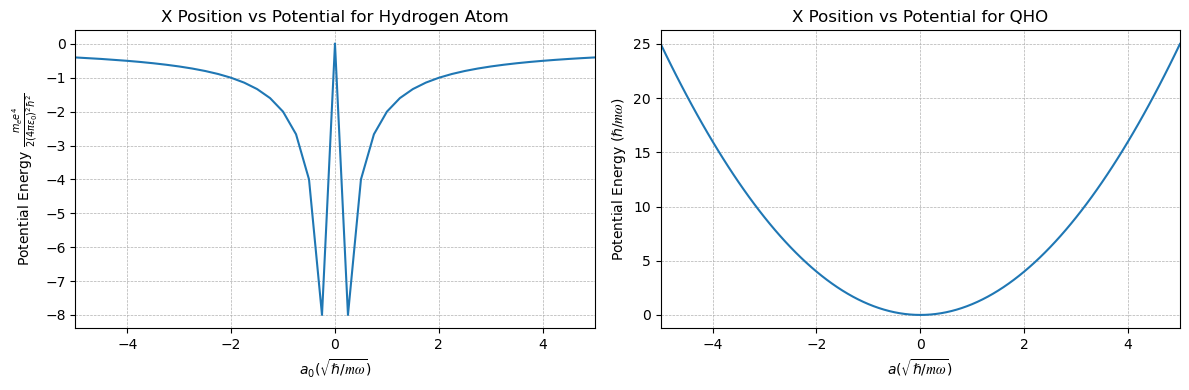

In [24]:
### - Calulate & Plotting Potential for Hydrogen Atom

#Calculate Potential using function
V_hydrogen = potential_hydrogen(r, l=0)     #Runs above function to calcualte the potential of the hydrogen atom 

#Plot Setup
plt.subplots(figsize=(12, 4), tight_layout=True)

#Hydrogen Atom Plot Setup
title = "X Position vs Potential for Hydrogen Atom" 
xlabel = "$a_0 (\sqrt{ℏ/𝑚𝜔})$"                  # Text encapsulated within two $ signs is rendered as latex, needed it to use non standard charecters i.e hbar, psi, etc 
ylabel = "Potential Energy $\\frac{m_e e^4}{2 (4 \pi \epsilon_0)^2 \hbar^2}$" 

#Hydrogen Atom Plotting
plt.subplot(1,2,1)
SimplePlotAssist(r, V_hydrogen, title=title, xlabel=xlabel, ylabel=ylabel)  #Plots the hydrogen atom potential 
plt.plot(-r,V_hydrogen, c="#1f77b4")                                        #Plots mirror image of the one sided hydrogen potential calcuated so it is reflected across x=0 as to compare to the QHO, colour used (c="#1f77b4") is the default matplotlib first plot colour so as to match the first half 
plt.grid(linestyle = '--', linewidth = 0.5)                                 #Adds grid to the plot to make it easier to read off values visualy
plt.xlim(-5,5)

#QHO Plot Setup
title = "X Position vs Potential for QHO" 
xlabel = "$a (\sqrt{ℏ/𝑚𝜔})$"                   # Text encapsulated within two $ signs is rendered as latex, needed it to use non standard charecters i.e hbar, psi, etc 
ylabel = "Potential Energy $(ℏ/𝑚𝜔)$" 

#QHO Plotting
plt.subplot(1,2,2)
SimplePlotAssist(x, V_qho, title=title, xlabel=xlabel, ylabel=ylabel)       #Plots the QHO potential 
plt.grid(linestyle = '--', linewidth = 0.5)                                 #Adds grid to the plot to make it easier to read off values visualy
plt.xlim(-5,5)
plt.show()

We can see how the potential energy gradient is differnt in each case, the QHO on the right is a parabola with the lowest energy at the zero displacement point (x=0), additonally the potential enegy values are positive. In contrast the Hydrogen potential energy (shown on the left), is 0 at r=0 as this is the point where the nucleus exists (in this approximation the nucleus is a point charge) the potential is negative values as the electron is bound to the nucleus. The shape of the hydrogen potential shows us that energy is required to move the electron away from the nucleus